In [1]:
import itertools
import warnings
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src.config import BLD, SRC
from src.estimation.gridsearch import (
    get_mask_around_diagonal,
    run_1d_gridsearch,
    run_2d_gridsearch,
)
from src.estimation.msm_criterion import (
    get_index_bundles,
    get_parallelizable_msm_criterion,
)
from src.manfred.shared import hash_array
from src.plotting.msm_plots import plot_estimation_moment, plot_infection_channels
from src.simulation.load_params import load_params
from src.simulation.load_simulation_inputs import load_simulation_inputs

DEBUG = False
FALL_SIM_START = pd.Timestamp("2020-09-15")
FALL_SIM_END = pd.Timestamp("2021-06-07")
SPRING_SIM_START = pd.Timestamp("2021-01-16")
SPRING_SIM_END = pd.Timestamp("2021-05-21")
if DEBUG:
    FALL_SIM_END = FALL_SIM_START + pd.Timedelta(days=3)
    SPRING_SIM_END = SPRING_SIM_START + pd.Timedelta(days=3)

warnings.filterwarnings(
    "ignore", message="indexing past lexsort depth may impact performance."
)
%load_ext snakeviz

# Load the simulation inputs

In [2]:
params = load_params("baseline")

pmsm = get_parallelizable_msm_criterion(
    prefix="gridsearch",
    fall_start_date=FALL_SIM_START,
    fall_end_date=FALL_SIM_END,
    spring_start_date=SPRING_SIM_START,
    spring_end_date=SPRING_SIM_END,
    mode="fall",
    debug=DEBUG,
)

# Modify Params

In [3]:
index_bundles = get_index_bundles(params)
hh_probs = index_bundles["hh"]
school_probs = index_bundles["school"]
young_educ_probs = index_bundles["young_educ"]
work_probs = index_bundles["work"]
other_probs = index_bundles["other"]

b117_rate = [("events", "b117_cases_per_100_000", "2021-01-31")]

vacation_probs = params.query("category == 'additional_other_vacation_contact'").index

rapid_test_level = [
    ("rapid_test_demand", "private_demand", "2021-03-31"),
    ("rapid_test_demand", "private_demand", "2021-04-06"),
]

free_probs = [
    bundle[0]
    for bundle in list(index_bundles.values())
    + [vacation_probs, b117_rate, rapid_test_level]
]

In [4]:
params.loc[other_probs, "value"] = 0.15875
params.loc[young_educ_probs, "value"] = 0.005
params.loc[school_probs, "value"] = 0.012
params.loc[work_probs, "value"] = 0.1475
params.loc[hh_probs, "value"] = 0.1
params.loc[vacation_probs, "value"] = 0.5
params.loc[free_probs]

value
category                          subcategory            name                        
infection_prob                    educ_school_0          educ_school_0        0.01200
                                  educ_preschool_0       educ_preschool_0     0.00500
                                  households             households           0.10000
                                  work_non_recurrent     work_non_recurrent   0.14750
                                  other_non_recurrent    other_non_recurrent  0.15875
additional_other_vacation_contact probability            Winterferien         0.50000
events                            b117_cases_per_100_000 2021-01-31           0.98500
rapid_test_demand                 private_demand         2021-03-31           0.22500

In [5]:
params

value
category           subcategory            name                             
infection_prob     households             households                  0.100
                   educ_school_0          educ_school_0               0.012
                   educ_school_1          educ_school_1               0.012
                   educ_school_2          educ_school_2               0.012
                   educ_preschool_0       educ_preschool_0            0.005
...                                                                     ...
rapid_test_demand  reaction               not_hh_contacts_multiplier  0.150
events             b117_cases_per_100_000 2021-01-01                  0.000
                                          2021-01-31                  0.985
seasonality_effect seasonality_effect     weak                        0.210
                                          strong                      0.420

[813 rows x 1 columns]

# Run estimation

In [6]:
dimensions = "1d"

n_gridpoints = 16
loc1 = b117_rate
gridspec1 = (0.97, 1.0, n_gridpoints)
# only used if 2d
loc2 = work_probs
gridspec2 = (0.14, 0.16, n_gridpoints)

n_seeds = 20
n_cores = 40
mask = None

In [7]:
if dimensions == "2d":
    results, grid, best_index, fig = run_2d_gridsearch(
        func=pmsm,
        params=params,
        loc1=loc1,
        gridspec1=gridspec1,
        loc2=loc2,
        gridspec2=gridspec2,
        n_seeds=n_seeds,
        n_cores=n_cores,
        mask=mask,
    )
else:
    results, grid, best_index, fig = run_1d_gridsearch(
        func=pmsm,
        params=params,
        loc=loc1,
        gridspec=gridspec1,
        n_seeds=n_seeds,
        n_cores=n_cores,
    )

/mnt/disks/disk-1/janos/miniconda3/envs/sid-germany/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [8]:
pd.to_pickle(results, "results.pkl")

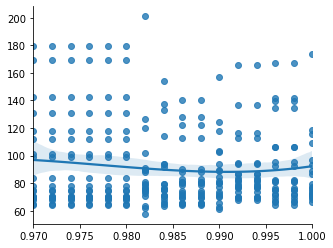

In [9]:
fig

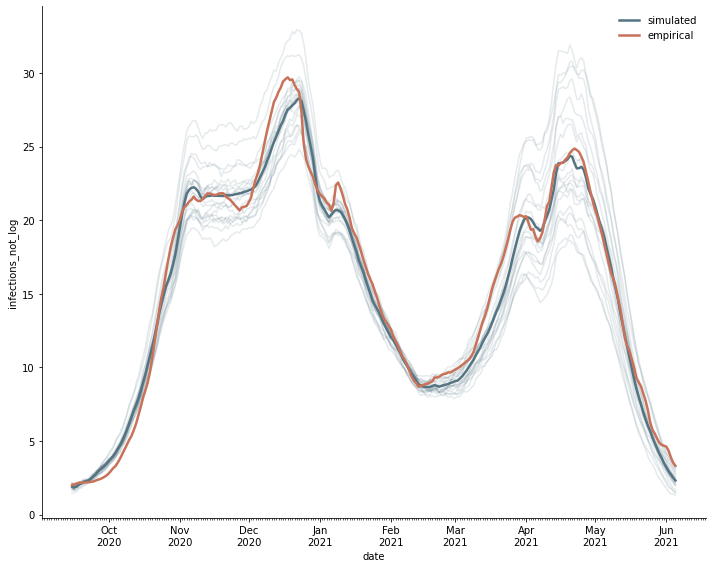

In [10]:
ix = best_index
plot_estimation_moment(results[ix], "aggregated_infections_not_log")

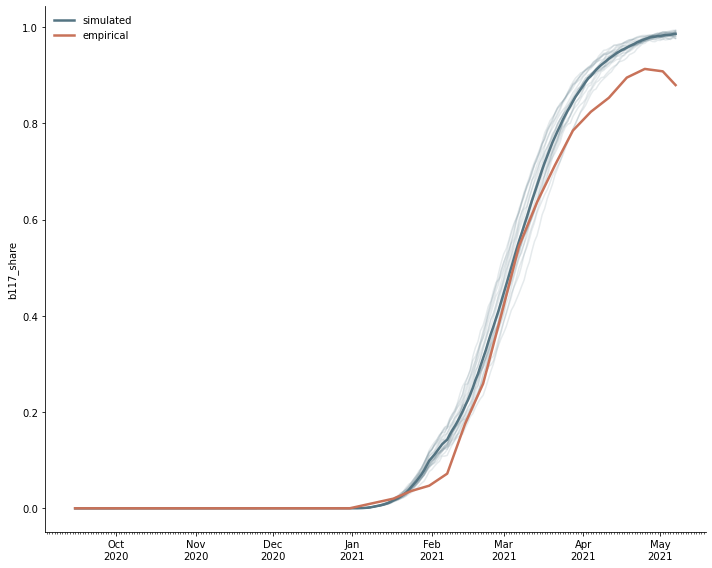

In [11]:
plot_estimation_moment(results[ix], "aggregated_b117_share")

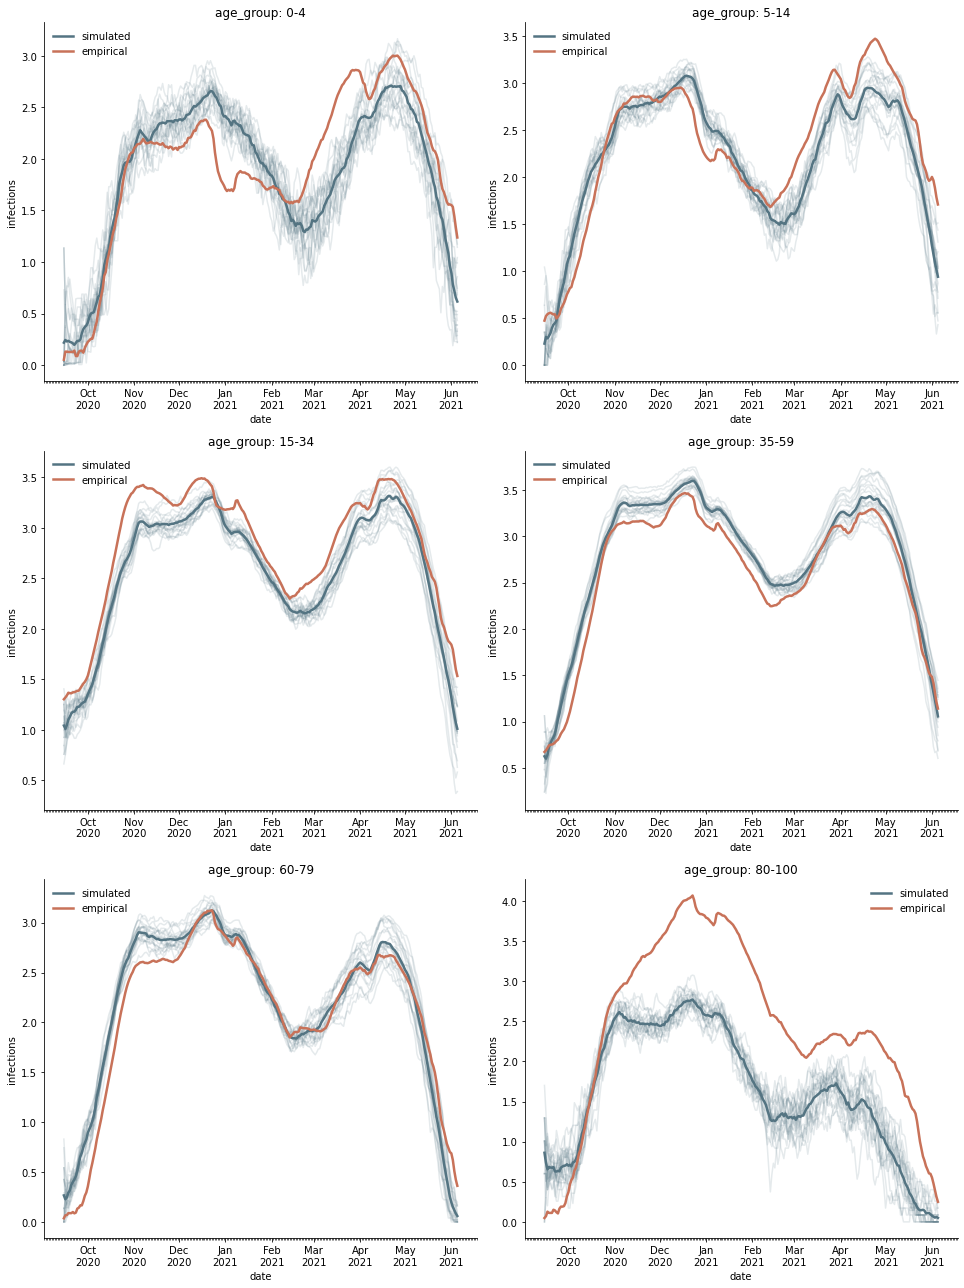

In [12]:
plot_estimation_moment(results[ix], "infections_by_age_group")

In [13]:
# plot_infection_channels(results[ix], aggregate=True)

In [14]:
grid[ix]

0.986

In [15]:
best_index

8

In [16]:
np.mean([res["value"] for res in results[best_index]])

85.19580137844608